# Transport efficiency and the models for tortuosity factor

Pybamm models utilize a ratio that we refer to as "transport efficiency" which can be applied to transport co-efficients such as the diffusivity in the electrolyte that relates the effective transport property through a porous media comprised of a conducting and non-conducting phase to that of the transport through the bulk of the conducting phase
$$
B = \frac{X_{eff}}{X_0} = \frac{\epsilon}{\tau},
$$

Where $\epsilon$ is the volume fraction of the conducting phase, the porosity of the electrode for diffusion within the electrolyte, and $\tau$ is the tortuosity factor. A measure of the effect of the increased pathlength that transported species traverse due to the presence of obstacles.

The tortuosity and tortuosity factor are often used interchangably but this can lead to confusion. Tortusosity is a purely geometric concept relating the length of a winding capillary pathway through a medium with the length of that medium, whereas tortuosity factor relates the the ratio of the transport property which may also depend on other factors such as anisotropic obstacles, boundary conditions of flow and also other physical phenomena such as the average pore size which could induce Knudsen effects. 

In essence it is a "fudge-factor" but many studies have been devoted to its understanding and there are many relations between $\tau$ and $\epsilon$ including those summarized by Shen & Chen [10]. By far the most common is the Bruggeman relation which is explored more recently by [Tjaden et al.](http://dx.doi.org/10.1016/j.coche.2016.02.006) in the context of materials commonly found in batteries and fuel cells.

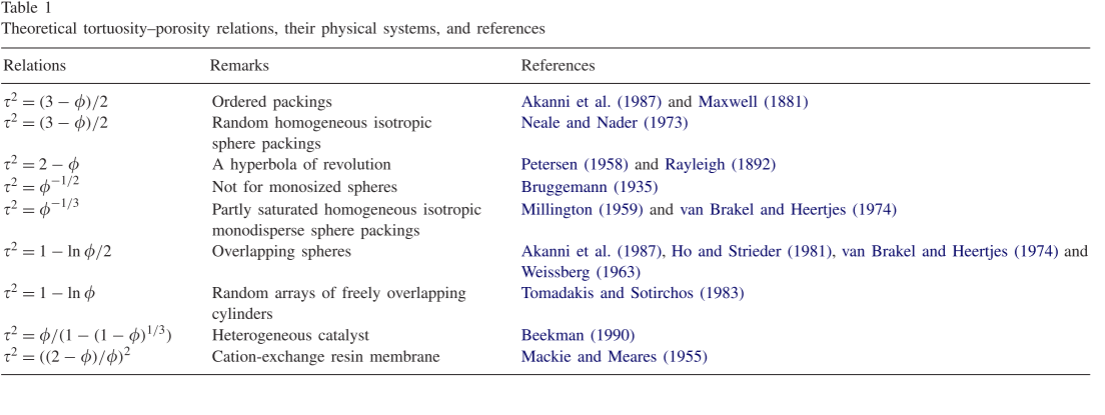

A recent study by [Usseglio-Viretta et al.](https://iopscience.iop.org/article/10.1149/2.0731814jes) found that Bruggeman and similar relations can significantly underpredict the tortuosity factors. If used at all these relations are often more suitable for the cathode where particles are more spherical but should be used with caution for the anode. A more recent trend is to use numerical methods to calculate tortuosity factors directly from image data gathered for electrodes in which case a straight-forward relation with porosity may not exist and is not necessary if factors can be directly supplied.

The remainder of the notebook demonstrates how to use the different options for transport efficiency and supply your own tortuosity factor

In [1]:
import pybamm
import numpy as np

In [2]:
sols = []
te_opts = pybamm.BatteryModelOptions({}).possible_options["transport efficiency"]
parameter_values = pybamm.ParameterValues("Marquis2019")
print(te_opts)

['Bruggeman', 'ordered packing', 'hyperbola of revolution', 'overlapping spheres', 'tortuosity factor', 'random overlapping cylinders', 'heterogeneous catalyst', 'cation-exchange membrane']


In [3]:
parameter_values.search("porosity")

Negative electrode porosity	0.3
Positive electrode porosity	0.3
Separator porosity	1.0


In [4]:
parameter_values.search("Bruggeman")

Negative electrode Bruggeman coefficient (electrode)	1.5
Negative electrode Bruggeman coefficient (electrolyte)	1.5
Positive electrode Bruggeman coefficient (electrode)	1.5
Positive electrode Bruggeman coefficient (electrolyte)	1.5
Separator Bruggeman coefficient (electrolyte)	1.5


Add tortuosity factors that replicate the Bruggeman values

In [5]:
parameter_values.update({'Negative electrode tortuosity factor (electrolyte)': 0.3**(-0.5),
                         'Positive electrode tortuosity factor (electrolyte)': 0.3**(-0.5),
                         'Negative electrode tortuosity factor (electrode)': 0.7**(-0.5),
                         'Positive electrode tortuosity factor (electrode)': 0.7**(-0.5),
                         'Separator tortuosity factor (electrolyte)': 1.0}, check_already_exists=False)

In [6]:
for t_label in te_opts:
    model = pybamm.lithium_ion.DFN(options={'transport efficiency': t_label})  # Doyle-Fuller-Newman model
    sim = pybamm.Simulation(model, parameter_values=parameter_values)
    sols.append(sim.solve([0, 3600]))  # solve for 1 hour

In [7]:
pybamm.dynamic_plot(sols,labels=te_opts)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

The Bruggeman and tortuosity factor results should be identical

In [8]:
np.allclose(sols[0]["Terminal voltage [V]"].data, sols[4]["Terminal voltage [V]"].data)

True

Now increase the tortuosity factors. N.B this will need to be calculated for specific electrodes with given porosity. Changing porosity in the model will not update the tortuosity factor unless a function is supplied for the parameter.

In [9]:
parameter_values.update({'Negative electrode tortuosity factor (electrolyte)': 4.0,
                         'Positive electrode tortuosity factor (electrolyte)': 4.0,
                         'Negative electrode tortuosity factor (electrode)': 3.0,
                         'Positive electrode tortuosity factor (electrode)': 3.0,
                         'Separator tortuosity factor (electrolyte)': 1.5}, check_already_exists=False)

In [10]:
model = pybamm.lithium_ion.DFN(options={'transport efficiency': "tortuosity factor"})  # Doyle-Fuller-Newman model
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sols.append(sim.solve([0, 3600]))

In [11]:
pybamm.dynamic_plot(sols,labels=te_opts+["higher tortuosity factor"])

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

The higher tortuosity leads to greater overpotential in the electrolyte and lower terminal voltage

In [12]:
pybamm.print_citations()

[1] KA Akanni, JW Evans, and IS Abramson. Effective transport coefficients in heterogeneous media. Chemical Engineering Science, 42(8):1945–1954, 1987.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] JW Beeckman. Mathematical description of heterogeneous materials. Chemical engineering science, 45(8):2603–2610, 1990.
[4] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[5] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[6] Charles R